# Visualizing predictions

We visualize here a single stay's monitor augmented with predictions. Ichilov and Mayo stays are processed, using models trained on the Ichilov dataset.

In [3]:
import os
import re
import pickle
import pandas
import numpy
import matplotlib.pyplot as plt
%matplotlib inline
try:
    import ipywidgets
except Exception as e:
    print("cannot import ipywidgets: {}".format(e))
    ipywidgets = None
pandas.options.mode.chained_assignment = None 

CONCEPTS = ["HR", "InvBPDias", "InvBPSys", "SpO2",
            "Temperature monitor", "Central Venous Pressure",
            "RRtotal"]

Let's choose a stay and prediction model to visualize. 
* The first choice in model parameters is apparently the best one. 
* The window is used to smoothen NLLs, 15 min for Mayo and 60 min for Ichilov give the best picture.
* The threshold is just for drawing red dashed line on the average perplexity plot.

There is a list of all stays in Ichilov and Mayo towards the bottom of the notebook, copy and paste from there, or just keep a list of stays you want to look at elsewhere.

In [4]:
DELAY = 1

MODELS = ["HR,SpO2,InvBPSys,InvBPDias,RRtotal"]
ARCHS = ["rnn-128-3-0.5", "rnn-256-4-0.5", "grnn-128-3-0.5", "grnn-256-5-0.5"]
DEPTHS = [15, 30, 5]
DELAYS = [1, 15, 5, 45]
WINDOWS = ['15min', '30min', '60min']
NLL_THRESHOLDS = (0, 4, 0.5)

STAYID = "Ichilov_MICU_23879"
MODEL = MODELS[0]
ARCH = ARCHS[0]
DEPTH = DEPTHS[0]
DELAY = DELAYS[0]
WINDOW = WINDOWS[0]
NLL_THRESHOLD = (NLL_THRESHOLDS[0] + NLL_THRESHOLDS[1])/2

if ipywidgets:
    @ipywidgets.interact
    def choose_stay(stayid=STAYID):
        global STAYID
        STAYID = stayid.strip()

    @ipywidgets.interact
    def choose_model(model=MODELS):
        global MODEL
        MODEL = model
        
    @ipywidgets.interact
    def choose_arch(arch=ARCHS):
        global ARCH
        ARCH = arch
        
    @ipywidgets.interact
    def choose_depth(depth=DEPTHS):
        global DEPTH
        DEPTH = depth
 
    @ipywidgets.interact
    def choose_delay(delay=DELAYS):
        global DELAY
        DELAY = delay
 
    @ipywidgets.interact
    def choose_stay(window=WINDOWS):
        global WINDOW
        WINDOW = window
        
    @ipywidgets.interact
    def choose_nll_threshold(nll_threshold=NLL_THRESHOLDS):
        global NLL_THRESHOLD
        NLL_THRESHOLD = nll_threshold

interactive(children=(Text(value='Ichilov_MICU_23879', description='stayid'), Output()), _dom_classes=('widget-interact',))

interactive(children=(Dropdown(description='model', options=('HR,SpO2,InvBPSys,InvBPDias,RRtotal',), value='HR,SpO2,InvBPSys,InvBPDias,RRtotal'), Output()), _dom_classes=('widget-interact',))

interactive(children=(Dropdown(description='arch', options=('rnn-128-3-0.5', 'rnn-256-4-0.5', 'grnn-128-3-0.5', 'grnn-256-5-0.5'), value='rnn-128-3-0.5'), Output()), _dom_classes=('widget-interact',))

interactive(children=(Dropdown(description='depth', options=(15, 30, 5), value=15), Output()), _dom_classes=('widget-interact',))

interactive(children=(Dropdown(description='delay', options=(1, 15, 5, 45), value=1), Output()), _dom_classes=('widget-interact',))

interactive(children=(Dropdown(description='window', options=('15min', '30min', '60min'), value='15min'), Output()), _dom_classes=('widget-interact',))

interactive(children=(FloatSlider(value=2.0, description='nll_threshold', max=4.0, step=0.5), Output()), _dom_classes=('widget-interact',))

In [13]:
STAY = "../data/monitor-dataset-{}-predict-{}-{}:{}-{}.pkl".format(STAYID, MODEL, DEPTH, DELAY, ARCH)
with open(STAY, "rb") as f:
    df = pickle.load(f)
# You can cut off a region of the dataframe like this:
# df = df[1*len(df)//2:5*len(df)//8]

## Per-axis predictions

For each concept we show two plots side by side. 
* On the left-hand plot the confidence intervals are shown (in pale orange). The  actual measurements are in blue.
* The right-hand plot shows negative log-likelihood (NLL) of predictions, averaged over a rolling window. The orange is the NLL. NLL should jump on low-confidence regions, corresponding to high variability or trend change. The pale blue background shows actual measurements, shifted two zero mean and scaled for easier comparison with NLL.

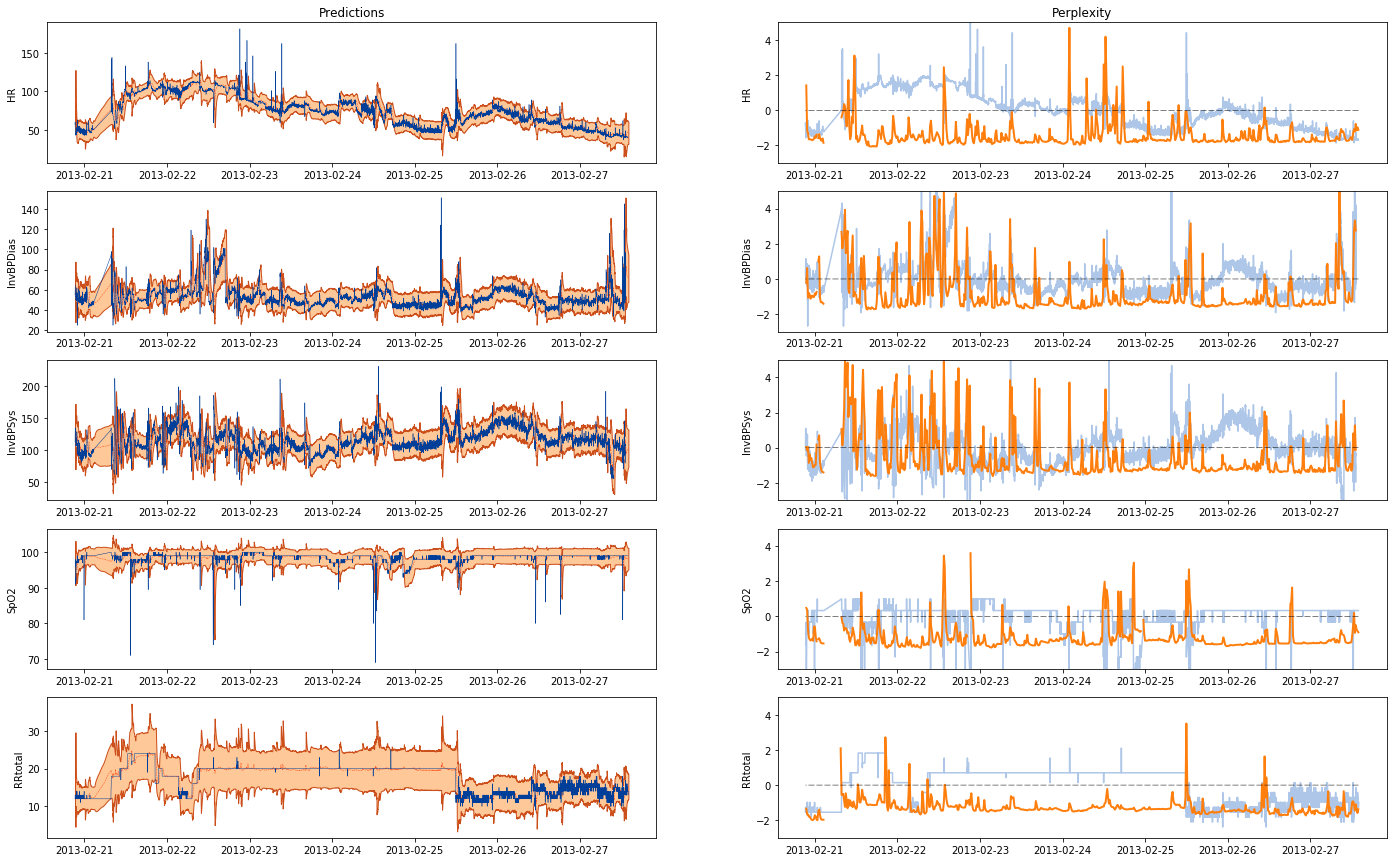

In [14]:
MAX_NLL = 5
MIN_NLL = -3

NSTDS = 2  # hose radius, in standard deviations

def cutoff(nll):
    """Cutoffs extreme NLL values for better presentation
    """
    shift = (MAX_NLL + MIN_NLL)/2
    scale = (MAX_NLL - MIN_NLL)/2
    return scale*numpy.tanh((nll - shift)/scale) + shift

def scale(concept):
    """Scales concept to display with NLL
    """
    return (concept - concept.mean())/concept.std()

concepts = [c for c in CONCEPTS if c + "_mean" in set(df.columns)]
fig, sps = plt.subplots(len(concepts), 2)
fig.set_figwidth(24)
fig.set_figheight(3*len(concepts))
avg_nll = None
any_avail = None
any_counts = None
for i, c in enumerate(concepts):
    avail = numpy.logical_not(numpy.isnan(df[c]))
    
    # Concept prediction
    mean = df[c + "_mean"]
    std = df[c + "_std"]
    sps[i, 0].fill_between(df.index, mean - NSTDS * std, mean + NSTDS * std,
                         edgecolor='#CC4F1B', facecolor='#FFC898')
    sps[i, 0].plot(mean, '--', lw=0.5, c='#FF4F1B')
    sps[i, 0].plot(df[c][avail], c='#003F99', lw=0.5)
    sps[i, 0].set_ylabel(c)
    
    # Concept perplexity
    zero = df[c].copy()
    zero[:] = 0.
    sps[i, 1].plot(scale(df[c][avail]), c='#AEC7E8')
    sps[i, 1].plot(cutoff(df[c + "_nll"][avail]).resample(rule=WINDOW).mean(), c='#FF7F0E', lw=2)
    sps[i, 1].plot(zero, c='black', linestyle=(-6, [12, 4]), lw=0.5)
    sps[i, 1].set_ylim((MIN_NLL, MAX_NLL))
    
    # Accumulate average perplexity
    c_nll = df[c + "_nll"].copy()
    c_nll[numpy.logical_not(avail)] = 0.
    c_counts = c_nll.copy()
    c_counts[:] = 0
    c_counts[avail] = 1
    if avg_nll is None:
        avg_nll = c_nll
        any_avail = avail
        any_counts = c_counts
    else:
        avg_nll += c_nll
        any_avail = numpy.logical_or(any_avail, avail)
        any_counts += c_counts
    
    sps[i, 1].set_ylabel(c)
avg_nll /= any_counts

sps[0, 0].set_title("Predictions")
sps[0, 1].set_title("Perplexity")

## Average log-perplexity

We draw average perplexity over all available measurements, averaged over a window. Faint lines in the background are normalized monitor measurements, for easier orientation.

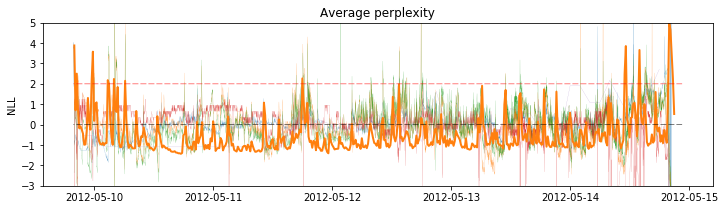

In [7]:
fig, sp = plt.subplots(1, 1)
fig.set_figwidth(12)
fig.set_figheight(3)
zero = avg_nll.copy()
zero[:] = 0.
threshold = avg_nll.copy()
threshold[:] = NLL_THRESHOLD
for c in concepts:
    avail = numpy.logical_not(numpy.isnan(df[c]))
    # we add here very faint monitor lines for orientation
    sp.plot(scale(df[c][avail]), lw=0.1*(1 + numpy.log(len(any_avail)/len(any_avail[any_avail]))))

win_nll = cutoff(avg_nll[any_avail]).resample(rule=WINDOW).mean()

sp.plot(win_nll, c='#FF7F0E', lw=2)
sp.plot(zero, c='black', linestyle=(-6, [12, 4]), lw=0.5)
sp.plot(threshold, c='red', linestyle=(-6, [12, 4]), lw=0.5)
sp.set_ylim((MIN_NLL, MAX_NLL))
sp.set_ylabel("NLL")
sp.set_title("Average perplexity")

## Appendix A: KS tag test

For stays from Ichilov, we can compare alerts to tags by performing a kind of KS test.

In [8]:
STAYS = "../data/stay_tags.pkl"
with open(STAYS, "rb") as f:
    stays = pickle.load(f)

if STAYID in stays:
    deterioration_tags = [tag for tag in stays[STAYID] if 'deterioration' in tag['concept']]
    print("{} has {} deterioration tags".format(STAYID, len(deterioration_tags)))
else:
    print("no deterioration tags in {}".format(STAYID))

Ichilov_MICU_20033 has 8 deterioration tags


Let's extract the tag time series.

In [9]:
times = sorted(set([tag['time'] for tag in deterioration_tags]))

tags = pandas.DataFrame({'time': times, 'tag': [1] * len(times)})
tags['time'] = pandas.to_datetime(tags['time'])
tags = tags.set_index('time')
tags = tags.reindex(df.index, fill_value=0)

Now let us merge the tags with window nll.

In [10]:
tags['nll'] = numpy.maximum(win_nll, 0) - 0
tags['nll'][numpy.isnan(tags['nll'])] = 0
tags['alert'] = numpy.sign(numpy.maximum(win_nll, NLL_THRESHOLD) - NLL_THRESHOLD)
tags['alert'][numpy.isnan(tags['alert'])] = 0

Finally, it's time to compute cumulative tags.

In [11]:
tags['cumtag'] = tags.cumsum()['tag']
tags['cumtag'] /= tags['cumtag'][-1]
tags['cumnll'] = tags.cumsum()['nll']
tags['cumnll'] /= tags['cumnll'][-1]
tags['cumalert'] = tags.cumsum()['alert']
tags['cumalert'] /= tags['cumalert'][-1]

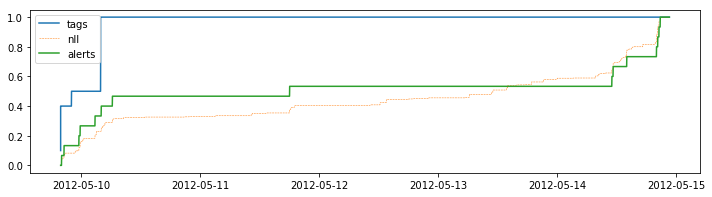

In [12]:
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(12)
fig.set_figheight(3)
ax.plot(tags['cumtag'], label='tags')
ax.plot(tags['cumnll'], '--', lw=0.5, label='nll')
ax.plot(tags['cumalert'], label='alerts')
ax.legend()

In [11]:
diffs = tags['cumalert'] - tags['cumtag']
print("KS statistics={:.4f} (max={:.4f} min={:.4f}, mean={:.4f})"
      .format(diffs.abs().max(), diffs.max(), diffs.min(), diffs.abs().mean()))

KS statistics=1.0000 (max=0.0000 min=-1.0000, mean=0.2756)


In [12]:
deterioration_tags

[{'concept': 'deterioration_pan_shock', 'time': '2008-07-07T15:07:00Z'}]

## Appendix B: stay lists

Copy and paste into the text field above.

### Mayo

In [13]:
for stay in sorted(os.listdir("../data")):
    m = re.match("^.*(Mayo_MICU_......._........)\.pkl", stay)
    if m:
        print(m.group(1))

Mayo_MICU_3003043_20840918
Mayo_MICU_3003AY3_20420313
Mayo_MICU_30040AY_20620101
Mayo_MICU_300483Y_20350504
Mayo_MICU_3006YA0_20390409
Mayo_MICU_3008330_20810505
Mayo_MICU_30099MA_20371213
Mayo_MICU_300A0AM_20381030
Mayo_MICU_300Y4A8_20621012
Mayo_MICU_300Y8YM_20600726
Mayo_MICU_300Y8YM_20600829
Mayo_MICU_303049Y_20311010
Mayo_MICU_30308MA_20430531
Mayo_MICU_303093M_20340821
Mayo_MICU_303300O_20361231
Mayo_MICU_3033M34_20840305
Mayo_MICU_3034Y46_20470602
Mayo_MICU_30369Y3_20690506
Mayo_MICU_3036AA0_20400908
Mayo_MICU_3036AA0_20400926
Mayo_MICU_3036AA0_20401013
Mayo_MICU_3036AA0_20401110
Mayo_MICU_303A840_20591026
Mayo_MICU_303AMMA_20590302
Mayo_MICU_3043O46_20611113
Mayo_MICU_3044A30_20351227
Mayo_MICU_3044A30_20351230
Mayo_MICU_304638M_20340830
Mayo_MICU_3046O38_20750805
Mayo_MICU_304A6A4_20491216
Mayo_MICU_304A990_20571213
Mayo_MICU_304A990_20580328
Mayo_MICU_304M343_20410316
Mayo_MICU_304M869_20540714
Mayo_MICU_304MY4Y_20730330
Mayo_MICU_304OOAO_20460916
Mayo_MICU_304Y64A_20420509
M

Mayo_MICU_3A30M60_20690113
Mayo_MICU_3A33394_20371103
Mayo_MICU_3A338O6_20400416
Mayo_MICU_3A346M3_20540423
Mayo_MICU_3A34MM9_20440619
Mayo_MICU_3A3849Y_20320401
Mayo_MICU_3A3A664_20510202
Mayo_MICU_3A3A664_20530705
Mayo_MICU_3A3A84O_20901026
Mayo_MICU_3A3M099_20500925
Mayo_MICU_3A3M630_20580715
Mayo_MICU_3A3O3A8_20640627
Mayo_MICU_3A3Y0M3_20760729
Mayo_MICU_3A3YM89_20431111
Mayo_MICU_3A4004O_20661212
Mayo_MICU_3A409MO_20650417
Mayo_MICU_3A44094_20480623
Mayo_MICU_3A4648O_20501108
Mayo_MICU_3A4648O_20501210
Mayo_MICU_3A4648O_20501221
Mayo_MICU_3A4648O_20501228
Mayo_MICU_3A46MM3_20960107
Mayo_MICU_3A48M0Y_20321111
Mayo_MICU_3A49646_20470410
Mayo_MICU_3A4AYO8_20770317
Mayo_MICU_3A4AYY8_20480218
Mayo_MICU_3A4OM0M_20330420
Mayo_MICU_3A4Y483_20330526
Mayo_MICU_3A66496_20340924
Mayo_MICU_3A693O4_20280202
Mayo_MICU_3A693O4_20280214
Mayo_MICU_3A6A698_20660509
Mayo_MICU_3A6AA6M_20380910
Mayo_MICU_3A6M8M9_20340529
Mayo_MICU_3A6O9MM_20590810
Mayo_MICU_3A6Y003_20690422
Mayo_MICU_3A6Y003_20690426
M

Mayo_MICU_6080338_20391006
Mayo_MICU_6080A49_20800126
Mayo_MICU_6083396_20490418
Mayo_MICU_6083396_20500128
Mayo_MICU_6083396_20540101
Mayo_MICU_6083396_20541126
Mayo_MICU_6083396_20541202
Mayo_MICU_60833A3_20630125
Mayo_MICU_60836O6_20500731
Mayo_MICU_60836YA_20790310
Mayo_MICU_6086408_20570121
Mayo_MICU_6086408_20570125
Mayo_MICU_6088848_20390702
Mayo_MICU_6088903_20511024
Mayo_MICU_6089649_20781012
Mayo_MICU_608AM80_20430618
Mayo_MICU_608AMYM_20720908
Mayo_MICU_608O903_20470810
Mayo_MICU_608O9O6_20661020
Mayo_MICU_608Y083_20971124
Mayo_MICU_60908OM_20780224
Mayo_MICU_60908OM_20780309
Mayo_MICU_60908OM_20780515
Mayo_MICU_6090AO6_20560613
Mayo_MICU_6096O63_20541208
Mayo_MICU_609806O_20550109
Mayo_MICU_6098390_20400623
Mayo_MICU_6098O36_20550510
Mayo_MICU_6098YYY_20570304
Mayo_MICU_6098YYY_20580123
Mayo_MICU_609A98Y_20340723
Mayo_MICU_609A98Y_20340810
Mayo_MICU_609AY3A_20770120
Mayo_MICU_609M903_20420226
Mayo_MICU_609MAOM_20330217
Mayo_MICU_609MYA0_20431115
Mayo_MICU_609O63M_20650626
M

Mayo_MICU_A00AOM0_20641206
Mayo_MICU_A00M484_20591212
Mayo_MICU_A00O4O8_20970316
Mayo_MICU_A00O4O8_20970325
Mayo_MICU_A00O4O8_20970509
Mayo_MICU_A00O4O8_20970517
Mayo_MICU_A00Y006_20420604
Mayo_MICU_A00Y8MO_20700426
Mayo_MICU_A00Y8MO_20720319
Mayo_MICU_A030609_20550306
Mayo_MICU_A030609_20551002
Mayo_MICU_A0333MM_20320916
Mayo_MICU_A033O08_20570809
Mayo_MICU_A033O08_20580224
Mayo_MICU_A033O08_20580401
Mayo_MICU_A034000_20640228
Mayo_MICU_A034M09_20640601
Mayo_MICU_A038639_20760708
Mayo_MICU_A0389OA_20770107
Mayo_MICU_A03AOY6_20750627
Mayo_MICU_A03M048_20640406
Mayo_MICU_A03M493_20411119
Mayo_MICU_A03M883_20560207
Mayo_MICU_A03M883_20560405
Mayo_MICU_A03M986_20280511
Mayo_MICU_A03MA94_20481227
Mayo_MICU_A03MM03_20600401
Mayo_MICU_A03MM4M_20520525
Mayo_MICU_A03MMAM_20570601
Mayo_MICU_A03O0AA_20921031
Mayo_MICU_A03O0AA_20961026
Mayo_MICU_A03OY9A_20531210
Mayo_MICU_A03Y99A_20440911
Mayo_MICU_A03Y99A_20441019
Mayo_MICU_A03Y99A_20441026
Mayo_MICU_A03Y99A_20441029
Mayo_MICU_A03Y99A_20460408
M

Mayo_MICU_AYA9M8A_20710627
Mayo_MICU_AYA9O04_20690930
Mayo_MICU_AYAA3A6_20450104
Mayo_MICU_AYAA904_20791102
Mayo_MICU_AYAM00M_20490515
Mayo_MICU_AYAM00M_20490517
Mayo_MICU_AYAO00O_20541017
Mayo_MICU_AYAO699_20790312
Mayo_MICU_AYAO699_20800121
Mayo_MICU_AYAY3OY_20550902
Mayo_MICU_AYAY48A_20480804
Mayo_MICU_AYAY4A6_20711128
Mayo_MICU_AYAY4A6_20720403
Mayo_MICU_AYAY4A6_20730220
Mayo_MICU_AYAY8AA_20540204
Mayo_MICU_AYAYM66_20910912
Mayo_MICU_AYAYM66_20910924
Mayo_MICU_AYM0086_20640212
Mayo_MICU_AYM0086_20640312
Mayo_MICU_AYM0Y0M_20611012
Mayo_MICU_AYM368O_20680520
Mayo_MICU_AYM39MO_20511102
Mayo_MICU_AYM3M84_20571204
Mayo_MICU_AYM3MMA_20630128
Mayo_MICU_AYM3MOY_20760730
Mayo_MICU_AYM3MY6_20520809
Mayo_MICU_AYM44AO_20571217
Mayo_MICU_AYM46YM_20590530
Mayo_MICU_AYM4993_20470127
Mayo_MICU_AYM4993_20470205
Mayo_MICU_AYM4A60_20370311
Mayo_MICU_AYM4AYM_20530926
Mayo_MICU_AYM4AYM_20531006
Mayo_MICU_AYM4OO6_20710317
Mayo_MICU_AYM66AO_20590929
Mayo_MICU_AYM66Y3_20810626
Mayo_MICU_AYM68AO_20720922
M

Mayo_MICU_O8YO943_20350504
Mayo_MICU_O8YO943_20370118
Mayo_MICU_O9M09O6_20541125
Mayo_MICU_O9YYM9M_20410610
Mayo_MICU_OM94YYM_20500716
Mayo_MICU_OM96648_20800609
Mayo_MICU_OMM9436_20440508
Mayo_MICU_OMM9436_20440606
Mayo_MICU_OOMO663_20660308
Mayo_MICU_OY00M8Y_21070529
Mayo_MICU_OY03O36_20700310
Mayo_MICU_OY04393_20780907
Mayo_MICU_OY04YA8_21041224
Mayo_MICU_OY06688_20971214
Mayo_MICU_OY06MMA_20850524
Mayo_MICU_OY084OO_20871105
Mayo_MICU_OY089OY_20560730
Mayo_MICU_OY0940Y_20430214
Mayo_MICU_OY09A90_20411122
Mayo_MICU_OY09AAM_20420502
Mayo_MICU_OY0M003_20581108
Mayo_MICU_OY0Y6M6_20721206
Mayo_MICU_OY3084M_20460725
Mayo_MICU_OY30O36_20620210
Mayo_MICU_OY34388_20420625
Mayo_MICU_OY36M90_20710407
Mayo_MICU_OY36M9M_20531111
Mayo_MICU_OY389M0_20580701
Mayo_MICU_OY39OY4_20840922
Mayo_MICU_OY39Y8M_20470620
Mayo_MICU_OY3MYA9_20540801
Mayo_MICU_OY3Y330_20741129
Mayo_MICU_OY3Y364_20790707
Mayo_MICU_OY40Y06_20770308
Mayo_MICU_OY44OO3_20540110
Mayo_MICU_OY46849_20570911
Mayo_MICU_OY46Y68_20340611
M

### Ichilov

In [27]:
for stay in sorted(os.listdir("../data")):
    m = re.match("^.*(Ichilov_MICU_.....)\.pkl", stay)
    if m:
        print(m.group(1))

Ichilov_MICU_20001
Ichilov_MICU_20002
Ichilov_MICU_20004
Ichilov_MICU_20005
Ichilov_MICU_20006
Ichilov_MICU_20007
Ichilov_MICU_20008
Ichilov_MICU_20009
Ichilov_MICU_20010
Ichilov_MICU_20011
Ichilov_MICU_20012
Ichilov_MICU_20013
Ichilov_MICU_20014
Ichilov_MICU_20015
Ichilov_MICU_20016
Ichilov_MICU_20017
Ichilov_MICU_20018
Ichilov_MICU_20019
Ichilov_MICU_20020
Ichilov_MICU_20021
Ichilov_MICU_20022
Ichilov_MICU_20023
Ichilov_MICU_20024
Ichilov_MICU_20025
Ichilov_MICU_20026
Ichilov_MICU_20027
Ichilov_MICU_20028
Ichilov_MICU_20029
Ichilov_MICU_20030
Ichilov_MICU_20031
Ichilov_MICU_20032
Ichilov_MICU_20033
Ichilov_MICU_20034
Ichilov_MICU_20035
Ichilov_MICU_20036
Ichilov_MICU_20037
Ichilov_MICU_20038
Ichilov_MICU_20039
Ichilov_MICU_20040
Ichilov_MICU_20041
Ichilov_MICU_20042
Ichilov_MICU_20043
Ichilov_MICU_20044
Ichilov_MICU_20045
Ichilov_MICU_20046
Ichilov_MICU_20047
Ichilov_MICU_20048
Ichilov_MICU_20049
Ichilov_MICU_20050
Ichilov_MICU_20051
Ichilov_MICU_20052
Ichilov_MICU_20053
Ichilov_MICU

Ichilov_MICU_21019
Ichilov_MICU_21020
Ichilov_MICU_21021
Ichilov_MICU_21022
Ichilov_MICU_21023
Ichilov_MICU_21024
Ichilov_MICU_21025
Ichilov_MICU_21026
Ichilov_MICU_21027
Ichilov_MICU_21028
Ichilov_MICU_21029
Ichilov_MICU_21030
Ichilov_MICU_21031
Ichilov_MICU_21032
Ichilov_MICU_21033
Ichilov_MICU_21034
Ichilov_MICU_21035
Ichilov_MICU_21036
Ichilov_MICU_21037
Ichilov_MICU_21038
Ichilov_MICU_21039
Ichilov_MICU_21040
Ichilov_MICU_21041
Ichilov_MICU_21042
Ichilov_MICU_21044
Ichilov_MICU_21045
Ichilov_MICU_21046
Ichilov_MICU_21047
Ichilov_MICU_21048
Ichilov_MICU_21049
Ichilov_MICU_21050
Ichilov_MICU_21051
Ichilov_MICU_21052
Ichilov_MICU_21053
Ichilov_MICU_21055
Ichilov_MICU_21056
Ichilov_MICU_21057
Ichilov_MICU_21058
Ichilov_MICU_21059
Ichilov_MICU_21060
Ichilov_MICU_21061
Ichilov_MICU_21062
Ichilov_MICU_21063
Ichilov_MICU_21064
Ichilov_MICU_21065
Ichilov_MICU_21066
Ichilov_MICU_21067
Ichilov_MICU_21068
Ichilov_MICU_21069
Ichilov_MICU_21070
Ichilov_MICU_21071
Ichilov_MICU_21072
Ichilov_MICU

Ichilov_MICU_22228
Ichilov_MICU_22229
Ichilov_MICU_22230
Ichilov_MICU_22231
Ichilov_MICU_22232
Ichilov_MICU_22233
Ichilov_MICU_22234
Ichilov_MICU_22235
Ichilov_MICU_22236
Ichilov_MICU_22237
Ichilov_MICU_22238
Ichilov_MICU_22239
Ichilov_MICU_22240
Ichilov_MICU_22241
Ichilov_MICU_22242
Ichilov_MICU_22243
Ichilov_MICU_22244
Ichilov_MICU_22245
Ichilov_MICU_22246
Ichilov_MICU_22247
Ichilov_MICU_22248
Ichilov_MICU_22249
Ichilov_MICU_22250
Ichilov_MICU_22251
Ichilov_MICU_22252
Ichilov_MICU_22253
Ichilov_MICU_22254
Ichilov_MICU_22255
Ichilov_MICU_22256
Ichilov_MICU_22257
Ichilov_MICU_22258
Ichilov_MICU_22260
Ichilov_MICU_22261
Ichilov_MICU_22262
Ichilov_MICU_22263
Ichilov_MICU_22264
Ichilov_MICU_22265
Ichilov_MICU_22266
Ichilov_MICU_22267
Ichilov_MICU_22268
Ichilov_MICU_22269
Ichilov_MICU_22270
Ichilov_MICU_22271
Ichilov_MICU_22272
Ichilov_MICU_22273
Ichilov_MICU_22274
Ichilov_MICU_22275
Ichilov_MICU_22276
Ichilov_MICU_22277
Ichilov_MICU_22278
Ichilov_MICU_22279
Ichilov_MICU_22280
Ichilov_MICU

Ichilov_MICU_23833
Ichilov_MICU_23834
Ichilov_MICU_23835
Ichilov_MICU_23836
Ichilov_MICU_23837
Ichilov_MICU_23838
Ichilov_MICU_23839
Ichilov_MICU_23840
Ichilov_MICU_23841
Ichilov_MICU_23842
Ichilov_MICU_23843
Ichilov_MICU_23844
Ichilov_MICU_23845
Ichilov_MICU_23846
Ichilov_MICU_23847
Ichilov_MICU_23848
Ichilov_MICU_23849
Ichilov_MICU_23850
Ichilov_MICU_23851
Ichilov_MICU_23852
Ichilov_MICU_23853
Ichilov_MICU_23854
Ichilov_MICU_23855
Ichilov_MICU_23856
Ichilov_MICU_23857
Ichilov_MICU_23858
Ichilov_MICU_23859
Ichilov_MICU_23861
Ichilov_MICU_23862
Ichilov_MICU_23863
Ichilov_MICU_23864
Ichilov_MICU_23865
Ichilov_MICU_23866
Ichilov_MICU_23867
Ichilov_MICU_23868
Ichilov_MICU_23869
Ichilov_MICU_23870
Ichilov_MICU_23871
Ichilov_MICU_23872
Ichilov_MICU_23873
Ichilov_MICU_23874
Ichilov_MICU_23875
Ichilov_MICU_23876
Ichilov_MICU_23877
Ichilov_MICU_23878
Ichilov_MICU_23879
Ichilov_MICU_23880
Ichilov_MICU_23881
Ichilov_MICU_23882
Ichilov_MICU_23883
Ichilov_MICU_23884
Ichilov_MICU_23885
Ichilov_MICU

Ichilov_MICU_25859
Ichilov_MICU_25860
Ichilov_MICU_25861
Ichilov_MICU_25862
Ichilov_MICU_25863
Ichilov_MICU_25864
Ichilov_MICU_25865
Ichilov_MICU_25866
Ichilov_MICU_25867
Ichilov_MICU_25868
Ichilov_MICU_25869
Ichilov_MICU_25870
Ichilov_MICU_25871
Ichilov_MICU_25872
Ichilov_MICU_25873
Ichilov_MICU_25874
Ichilov_MICU_25875
Ichilov_MICU_25876
Ichilov_MICU_25877
Ichilov_MICU_25878
Ichilov_MICU_25880
Ichilov_MICU_25881
Ichilov_MICU_25882
Ichilov_MICU_25883
Ichilov_MICU_25884
Ichilov_MICU_25885
Ichilov_MICU_25886
Ichilov_MICU_25887
Ichilov_MICU_25888
Ichilov_MICU_25889
Ichilov_MICU_25890
Ichilov_MICU_25891
Ichilov_MICU_25892
Ichilov_MICU_25893
Ichilov_MICU_25894
Ichilov_MICU_25895
Ichilov_MICU_25896
Ichilov_MICU_25897
Ichilov_MICU_25898
Ichilov_MICU_25899
Ichilov_MICU_25900
Ichilov_MICU_25901
Ichilov_MICU_25902
Ichilov_MICU_25903
Ichilov_MICU_25904
Ichilov_MICU_25905
Ichilov_MICU_25906
Ichilov_MICU_25907
Ichilov_MICU_25908
Ichilov_MICU_25909
Ichilov_MICU_25910
Ichilov_MICU_25911
Ichilov_MICU

Ichilov_MICU_27874
Ichilov_MICU_27875
Ichilov_MICU_27876
Ichilov_MICU_27877
Ichilov_MICU_27878
Ichilov_MICU_27879
Ichilov_MICU_27880
Ichilov_MICU_27881
Ichilov_MICU_27882
Ichilov_MICU_27883
Ichilov_MICU_27885
Ichilov_MICU_27886
Ichilov_MICU_27887
Ichilov_MICU_27888
Ichilov_MICU_27889
Ichilov_MICU_27890
Ichilov_MICU_27891
Ichilov_MICU_27892
Ichilov_MICU_27893
Ichilov_MICU_27894
Ichilov_MICU_27895
Ichilov_MICU_27896
Ichilov_MICU_27897
Ichilov_MICU_27898
Ichilov_MICU_27899
Ichilov_MICU_27900
Ichilov_MICU_27901
Ichilov_MICU_27902
Ichilov_MICU_27903
Ichilov_MICU_27904
Ichilov_MICU_27905
Ichilov_MICU_27906
Ichilov_MICU_27907
Ichilov_MICU_27908
Ichilov_MICU_27909
Ichilov_MICU_27910
Ichilov_MICU_27911
Ichilov_MICU_27912
Ichilov_MICU_27913
Ichilov_MICU_27914
Ichilov_MICU_27915
Ichilov_MICU_27916
Ichilov_MICU_27917
Ichilov_MICU_27918
Ichilov_MICU_27919
Ichilov_MICU_27920
Ichilov_MICU_27921
Ichilov_MICU_27922
Ichilov_MICU_27923
Ichilov_MICU_27924
Ichilov_MICU_27925
Ichilov_MICU_27926
Ichilov_MICU